# 1. Data Overview and Preparation
### Description
Climate Canada provides access to historical weather data through its historical climate data [web app](http://climate.weather.gc.ca/historical_data/search_historic_data_e.html).  The data is produced by sensors installed at [weather stations](https://en.wikipedia.org/wiki/Weather_station) located at geographically dispersed locations accross Canada.

> A **weather station** is a facility, either on land or sea, with instruments and equipment for measuring atmospheric conditions to provide information for weather forecasts and to study the weather and climate.

Data is available at monthly, daily, and hourly intervals on a per-weather station basis with data missing for some combinations of interval, station, and timeframe e.g. monthly data for London weather stations, data aggregated up to the monthly level, is generally not available but daily data is.  The availability for a particular time interval (e.g. for the month of December) varies accross stations; some stations are missing entire months of data.  This will not pose a significant problem as we are not interested in station-level measurements but rather overall weather trends in London, Ontario.  Data accross stations is aggregated so that the daily measurements from each station are averaged to produce a single measurement value (see [1.5](#1.5-Daily-Observation-Data)).  When data is missing from one station, it is generally available from another.

The different time intervals (monthly, daily, hourly) provide different measurements.  Daily weather data (available through the Climate Canada website by year/month) contains both precipitation and weather data and is the most suitable level of granularity for this analysis so it's the level of granularity that will be used here.  The variable descriptions are described further in [[1](http://climate.weather.gc.ca/glossary_e.html)].		


### Retrieving Weather Data
Historical weather data produced by weather stations can be obtained through Climate Canada's search system that accepts queries for station names, province, or proximity as shown below.

<img src ="../images/station_search.png" style="height: 400px;" />

After selecting a station, data can be requested at hourly, daily, or monthly intervals.

<img src ="../images/station_result.png" style="height: 400px;" />

This analysis will focus on data from weather stations deployed in London Ontario, Canada so the search term used to find relevant stations and the associated data included only the keyword "London".  

After using the Climate Canada web app to identify stations in London Ontario, only those with monthly data (data for every day of the month) available for at least five years were considered for the analysis.  The London CS, London Airport, and London A stations met this critera and monthly data for the stations were retrieved from Climate Canada's web application using a Python program built using the web scraping framework [Scrapy](#).  The program automates the data retrieval process by generating search requests for station data for the stations of interest for every month from January 1, 2012 to July 13, 2017 and uses [XPath](https://developer.mozilla.org/en-US/docs/Web/XPath) to extract data from the HTML table show below.  

<img src ="../images/station_report.png" style="height: 400px;" />

All of the data is appended to a CSV file where each row represents a day of observed data from each one of the stations.  Code for the web scraper can be found [here](https://github.com/calvdee/ldn-ont-precip/tree/master/webcrawler).  For the ambitious reader, the code can be cloned from GitHub and the CSV can be populated with data upto today's date by running the following at the command line:

```
cd ../webcrawler
scrapy crawl daily_spider
```

## 1.2 Data Prep

In [265]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [266]:
# Load daily weather data produced by web scraper
dwd = pd.read_csv("../data/scrapy_2017-08-25.csv", parse_dates=['date'])

In [267]:
pd.DataFrame(index=dwd.describe().transpose().index)

""
station
date
maxTemp
minTemp
meanTemp
heatDegDays
coolDegDays
totalRainMM
totalSnowCM
totalPrecipMM


Look at the first few observations

In [268]:
dwd.head()

,station,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,London CS,2010-02-01,-4.9,-10.0,-7.5,25.5,0.0,NaN,NaN,0.0,,NaN,NaN
1,London CS,2010-02-02,-3.1,-11.4,-7.3,25.3,0.0,NaN,NaN,2.5,,NaN,NaN
2,London CS,2010-02-03,-1.1,-5.2,-3.2,21.2,0.0,NaN,NaN,1.2,,NaN,NaN
3,London CS,2010-02-04,-1.2,-12.0,-6.6,24.6,0.0,NaN,NaN,0.0,,NaN,NaN
4,London CS,2010-02-05,-0.3,-8.7,-4.5,22.5,0.0,NaN,NaN,0.0,,NaN,NaN


In [269]:
print(dwd.date.min(), dwd.date.max())

2010-01-01 00:00:00 2017-08-25 00:00:00


It's obvious that there's some missing data.  As observed while exploring data through the website, some measurements include an empty value while others include the value 'M'.

In [270]:
dwd.shape

(6249, 13)

6133 observatiions, 13 variables

In [271]:
dwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6249 entries, 0 to 6248
Data columns (total 13 columns):
station               6249 non-null object
date                  6249 non-null datetime64[ns]
maxTemp               6223 non-null object
minTemp               6232 non-null object
meanTemp              6212 non-null object
heatDegDays           6212 non-null object
coolDegDays           6212 non-null object
totalRainMM           1460 non-null object
totalSnowCM           1298 non-null object
totalPrecipMM         4040 non-null object
snowOnGroundCM        6086 non-null object
dirOfMaxGust10sDEG    3463 non-null object
spdOfMaxGustKMH       3463 non-null object
dtypes: datetime64[ns](1), object(12)
memory usage: 634.7+ KB


In [272]:
print("{} to {}".format(dwd.date.min(), dwd.date.max()))

2010-01-01 00:00:00 to 2017-08-25 00:00:00


Transform the columns to the appropriate data types

In [273]:
# Discrete columns
disc = ['station', 'date']

In [274]:
# Continuous data with empty values replaced with `NaN` and '<31' with 31
# i.e. the indicator function I
data_cont = pd.DataFrame.replace(
  pd.DataFrame(dwd[dwd.columns.drop(disc)]),
  ["\xa0", "<31"],
  ["NaN", 31]).astype(float)
data_disc = dwd[disc]

Discrete

In [275]:
pd.DataFrame(index=disc)

""
station
date


Continuous

In [276]:
pd.DataFrame(index=data_cont.columns)

""
maxTemp
minTemp
meanTemp
heatDegDays
coolDegDays
totalRainMM
totalSnowCM
totalPrecipMM
snowOnGroundCM
dirOfMaxGust10sDEG


Final dataset

In [277]:
df = pd.concat([data_cont, data_disc], axis=1)

Summary statistics

In [278]:
cm = sns.light_palette("red", as_cmap=True)
s = df.describe().transpose().style.background_gradient(cmap=cm)
s

,count,mean,std,min,25%,50%,75%,max
maxTemp,4754,13.6105,11.6482,-19,3.8,15,24,36.7
minTemp,4763,3.57029,10.1317,-30.5,-3.1,3.8,11.9,24.6
meanTemp,4743,8.60268,10.7473,-24.5,0.4,9.3,17.9,30.7
heatDegDays,4743,10.2295,9.75357,0,0.1,8.7,17.6,42.5
coolDegDays,4743,0.832153,1.82886,0,0,0,0,12.7
totalRainMM,1243,1.55559,4.48242,0,0,0,0,39.3
totalSnowCM,1081,1.28992,3.10682,0,0,0,1,35
totalPrecipMM,3823,2.68671,5.96195,0,0,0,2.5,69.7
snowOnGroundCM,1553,7.86413,10.6616,0,0,3,11,59
dirOfMaxGust10sDEG,124,20.4597,10.2833,1,13,20,30,36


* Highest observed temperature is 36.7°C
* Minimum observed temperature is -30.5°C
* Average observed temperature is 8.3°C
* All variables except for temperature-related variables are strictly positive
* Temperature varries more than precipitation

## 1.3 Missing Data

Measurements from sensors produced at weather station locations are [noisy](http://climate.weather.gc.ca/climate_data/data_quality_e.html) i.e. values may be innacurate or they  may be missing.

How many records are missing measurements?

In [279]:
df.isnull().sum()

maxTemp               1495
minTemp               1486
meanTemp              1506
heatDegDays           1506
coolDegDays           1506
totalRainMM           5006
totalSnowCM           5168
totalPrecipMM         2426
snowOnGroundCM        4696
dirOfMaxGust10sDEG    6125
spdOfMaxGustKMH       4255
station                  0
date                     0
dtype: int64

In [280]:
df.isnull().sum() / len(df)

maxTemp               0.239238
minTemp               0.237798
meanTemp              0.240999
heatDegDays           0.240999
coolDegDays           0.240999
totalRainMM           0.801088
totalSnowCM           0.827012
totalPrecipMM         0.388222
snowOnGroundCM        0.751480
dirOfMaxGust10sDEG    0.980157
spdOfMaxGustKMH       0.680909
station               0.000000
date                  0.000000
dtype: float64

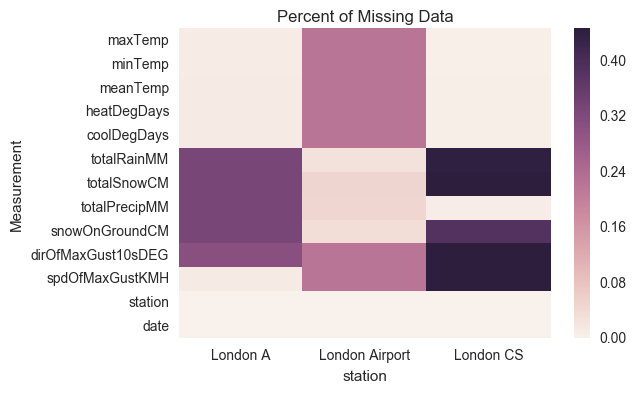

In [281]:
_ = sns.heatmap((df.groupby('station').apply(lambda x: pd.isnull(x).sum()) / df.shape[0]).transpose())
_.set_title("Percent of Missing Data");
_.set_ylabel("Measurement");

* The **London A** is missing precipitation measurements
* The **London Airport** station is missing temperature and wind data but has most complete precipitation and rain measurements
* The **London CS** is missing significant wind, rain, and snow measurements

The only variable with a significant number of missing values accross stations is `dirOfMaxGust10sDEG`.  With a sufficient amount of data available from a combination of the three stations for all other relevant variables, we can summarize the daily measurements using the arithmetic mean of measurements.

## 1.4 Daily Observation Data
Since we are not ultimately not interested in measurements from individual weather stations (the purpose of this analysis is to analyze precipitation trends in London Ontario as a whole), we can collapse observations from different locations into a single measurement by taking the arithmetic mean of multiple measurements.

In [282]:
daily_df = df.set_index('date').resample('1D').mean()
daily_df.head()

,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
date,,,,,,,,,,,
2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN


In [283]:
print("{} to {}".format(daily_df.index.min(), daily_df.index.max()))

2010-01-01 00:00:00 to 2017-08-25 00:00:00


### Seasons
Adding a seasonal indicator will allow us to visualize seasonal weather effects (if any).  Seasonal bounds for the Northern hemisphere are used to label each observation below
> [...] for temperate areas in the northern hemisphere, spring begins on 1 March, summer on 1 June, autumn on 1 September, and winter on 1 December. - [Wikipedia](https://en.wikipedia.org/wiki/Season#Meteorological).

In [284]:
# Seasons
def season(date):
  if date.month == 12 or date.month < 3:
    # December - Feb
    return 'winter'
  elif date.month >= 3 and date.month < 6:
    # March - June
    return 'spring'
  elif date.month >= 6 and date.month < 9:
    # June - Sept
    return 'summer'
  else:
    # Sept - Nov
    return 'fall'

In [285]:
daily_df['season'] = pd.Series(daily_df.index).apply(season).values

### Dates
Add date components as separate columns so we can aggregate the data more easily

In [286]:
daily_df['year'] = pd.Series(daily_df.index).apply(lambda x: x.year).values
daily_df['month'] = pd.Series(daily_df.index).apply(lambda x: x.month).values
daily_df.head()

,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,season,year,month
date,,,,,,,,,,,,,,
2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN,winter,2010,1
2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN,winter,2010,1
2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN,winter,2010,1
2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN,winter,2010,1
2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN,winter,2010,1


Save the data to CSV

In [287]:
csv_name = "../data/notebook1_weather_by_day_{}.csv".format(daily_df.index.max())
daily_df.to_csv(csv_name, index=True)
daily_df = pd.read_csv(csv_name, date_parser=['date'])
print(csv_name)
print(daily_df.info())
daily_df.head()

../data/notebook1_weather_by_day_2017-08-25 00:00:00.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2794 entries, 0 to 2793
Data columns (total 15 columns):
date                  2794 non-null object
maxTemp               2792 non-null float64
minTemp               2793 non-null float64
meanTemp              2792 non-null float64
heatDegDays           2792 non-null float64
coolDegDays           2792 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2754 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1987 non-null float64
season                2794 non-null object
year                  2794 non-null int64
month                 2794 non-null int64
dtypes: float64(11), int64(2), object(2)
memory usage: 327.5+ KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,season,year,month
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN,winter,2010,1
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN,winter,2010,1
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN,winter,2010,1
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN,winter,2010,1
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN,winter,2010,1
